In [1]:
import tensorflow as tf


from keras.models import load_model


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
model = load_model('/content/drive/MyDrive/DataSet/Ann_Training.h5')

In [4]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 1000)                │       7,198,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 28)                  │          14,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,712,530 (29.42 MB)

 Trainable params: 7,712,528 (29.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import f1_score

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight

Lb = LabelEncoder()

In [6]:
directory = '/content/drive/MyDrive/DataSet/NearEarthAsteroids'
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
csv_files

['asteroid_from_0_to_600.csv',
 'asteroid_from_600_to_1200.csv',
 'asteroid_from_1200_to_1800.csv',
 'asteroid_from_1800_to_2400.csv']

In [7]:
df = pd.read_csv(os.path.join(directory, csv_files[0]), nrows=2)
x_feature = pd.read_csv(os.path.join(directory, csv_files[0]), usecols=lambda column: df.columns.get_loc(column) >= 3, dtype='float32')

for i in range(1, len(csv_files)):
  df = pd.read_csv(os.path.join(directory, csv_files[i]), nrows=2)
  data = pd.read_csv(os.path.join(directory, csv_files[i]), usecols=lambda column: df.columns.get_loc(column) >= 3, dtype='float32')
  x_feature = pd.concat([x_feature, data], axis=1)
  print(f"Finished {i} : data shape: {x_feature.shape}")

Finished 1 : data shape: (281543, 3600)
Finished 2 : data shape: (281543, 5397)
Finished 3 : data shape: (281543, 7197)


In [8]:
x = x_feature.values
x, x.shape

(array([[-0.12893952, -0.7659941 ,  0.5514655 , ..., -0.19785312,
          0.8052923 , -0.21108072],
        [-0.11773851, -0.76766   ,  0.5482398 , ..., -0.20630932,
          0.7981831 , -0.21056218],
        [-0.10848359, -0.768929  ,  0.54555035, ..., -0.21308967,
          0.79228103, -0.21011032],
        ...,
        [-1.340345  , -2.8070676 ,  0.26816002, ..., -0.3807464 ,
         -0.80934566,  0.11360447],
        [-1.339573  , -2.8069007 ,  0.26825997, ..., -0.38021505,
         -0.809762  ,  0.11365477],
        [-1.3329223 , -2.8054514 ,  0.26912138, ..., -0.3756226 ,
         -0.81334275,  0.11408573]], dtype=float32),
 (281543, 7197))

In [9]:
y_data = pd.read_csv('/content/drive/MyDrive/DataSet/Labels/Plate_dataset_mag405.csv')
y_data['nearest_cluster']

,nearest_cluster
0,Cluster24
1,Cluster12
2,Cluster12
3,Cluster1
4,Cluster12
...,...
281538,Cluster12
281539,Cluster1
281540,Cluster7
281541,Cluster14


In [10]:
y_label = y_data
Lb = LabelEncoder()
y_labe = Lb.fit_transform(y_label['nearest_cluster'])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labe),
    y=y_labe
)

class_weights_dict = dict(enumerate(class_weights))

one_encode = OneHotEncoder()
y = one_encode.fit_transform(y_labe.reshape(-1, 1)).toarray()

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in stratified_split.split(x, y_label['nearest_cluster']):
    x_train, x_r = x[train_index], x[test_index]
    y_train, y_r = y[train_index], y[test_index]
    y_train_cluster, y_r_cluster = y_label['nearest_cluster'].iloc[train_index], y_label['nearest_cluster'].iloc[test_index]

stratified_split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.333, random_state=45)

for val_index, test_index in stratified_split_val_test.split(x_r, y_r_cluster):
    x_val, x_test = x_r[val_index], x_r[test_index]
    y_val, y_test = y_r[val_index], y_r[test_index]

In [ ]:
y_data['encode_cluster'] = y_labe


In [29]:
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, input_shape=(x_train.shape[1], 1), activation=tf.keras.activations.softmax))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, activation=tf.keras.activations.softmax))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())

# model.add(Dense(units=64, activation=tf.keras.activations.softmax))
# model.add(Dense(units=32, activation=tf.keras.activations.softmax))
# model.add(Dense(units=y_train.shape[1], activation=tf.keras.activations.softmax))


model = Sequential()
model.add(Dense(units=250, input_shape=(x_train.shape[1],), activation='softmax'))
model.add(Dense(units=64, activation='softmax'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping_callback]) #, class_weight=class_weights_dict

Epoch 1/30
6159/6159 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.2653 - loss: 2.7094 - val_accuracy: 0.2715 - val_loss: 2.5448
Epoch 2/30
6159/6159 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.2725 - loss: 2.5432 - val_accuracy: 0.2715 - val_loss: 2.5447
Epoch 3/30
6159/6159 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.2706 - loss: 2.5484 - val_accuracy: 0.2715 - val_loss: 2.5448
Epoch 4/30
6159/6159 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.2712 - loss: 2.5477 - val_accuracy: 0.2715 - val_loss: 2.5449


In [31]:
model.save('/content/drive/MyDrive/DataSet/Ann-None-ClassWeigth_Training.h5')

879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


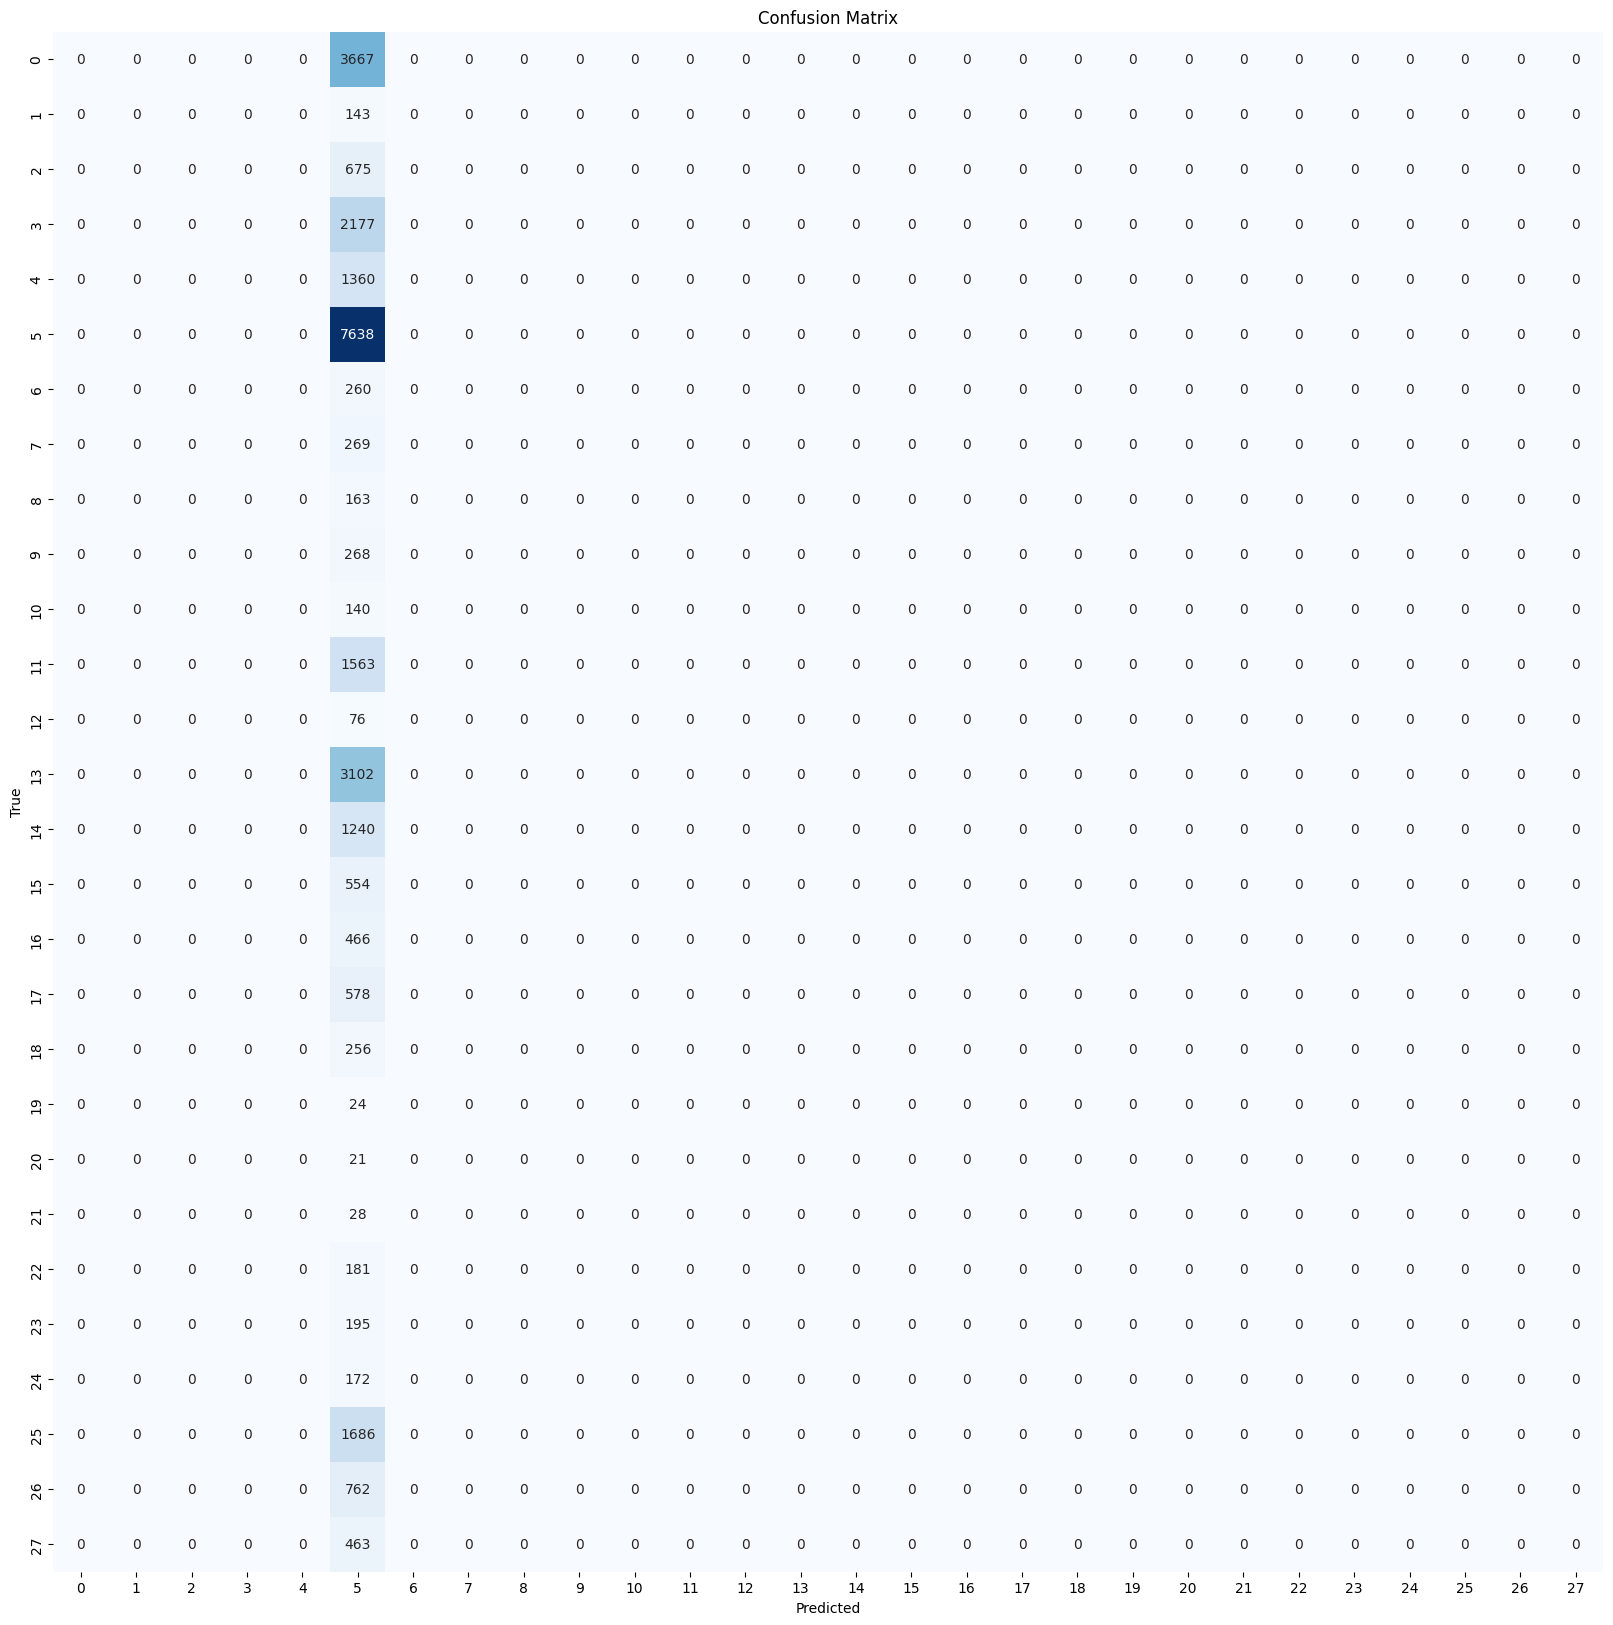

In [32]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_actual = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_actual, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
f1 = f1_score(y_actual, y_pred, average='macro')
print(f1)

0.015254338838848833
